# Exploring AE, DAE and CAE with MNIST
1. We consider basic/undercomplete AE, denoising AE (DAE) and contractive AE (CAE)
2. For CAE, I need to find out whether there is a more efficient way of computing Jacobian

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.contrib.slim as slim


In [2]:
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

image_dim = 784 # MNIST images are 28x28 pixels
hidden_dim = 32
latent_dim = 2

(60000, 784)
(10000, 784)


## Basic AE
1. Learning Rate is a very important Hyperparam: usually 0.01 is good
2. Adam or Adadelta are usually good
3. If normalized, use tf.variance_scaling_initializer() for fast convergence

In [3]:
def basic_ae(n_hidden, input_dim, reg=None, reg_param=None):
    """
        Though named basic, this function is able to create undercomplete AE,
        Sparse AE, and AE with dropout
    """
    initializer = tf.variance_scaling_initializer()
    X_ph = tf.placeholder(tf.float32, shape=(None, input_dim))
    W_1 = tf.Variable(initializer([input_dim, n_hidden]), dtype=tf.float32)
    b_1 = tf.Variable(tf.zeros(n_hidden), dtype=tf.float32)
    z_1 = tf.matmul(X_ph, W_1) + b_1
    a_1 = tf.nn.sigmoid(z_1)
    if reg == 'dropout':
        encoded = tf.nn.dropout(a_1, rate=reg_param) # reg_param = 1 - keep_prob here
    else:
        encoded = a_1
    W_2 = tf.Variable(initializer([n_hidden, input_dim]), dtype=tf.float32)
    b_2 = tf.Variable(tf.zeros(input_dim), dtype=tf.float32)
    z_2 = tf.matmul(encoded, W_2) + b_2
    a_2 = tf.nn.sigmoid(z_2)
    if reg == 'dropout':
        decoded = tf.nn.dropout(a_2, rate=reg_param) # reg_param = 1 - keep_prob here
    else:
        decoded = a_2
    
    if reg == 'l1':
        # divide reg_param by two as we ought to take avg of the two tf.reduce_mean
        reg_factor = tf.constant(reg_param/2)
        loss = tf.reduce_mean(tf.square(decoded-X_ph)) +\
                reg_factor*(tf.reduce_mean(tf.abs(W_1)) + tf.reduce_mean(tf.abs(W_2)))
    else:
        loss = tf.reduce_mean(tf.square(decoded-X_ph))
        
    optimizer = tf.train.AdamOptimizer(0.01)
    train_op = optimizer.minimize(loss)
    
    return X_ph, encoded, decoded, loss, train_op

1/50 finished, training loss: 0.05416003382454316
2/50 finished, training loss: 0.03616567375138402
3/50 finished, training loss: 0.030361726582050323
4/50 finished, training loss: 0.027638972625136374
5/50 finished, training loss: 0.02627303165073196
6/50 finished, training loss: 0.025521348242958385
7/50 finished, training loss: 0.02478519782423973
8/50 finished, training loss: 0.023252397266527017
9/50 finished, training loss: 0.02178293337424596
10/50 finished, training loss: 0.020352860831966003
11/50 finished, training loss: 0.018765430065492788
12/50 finished, training loss: 0.017738567863901458
13/50 finished, training loss: 0.016748132122059663
14/50 finished, training loss: 0.01603786164584259
15/50 finished, training loss: 0.015499908681958914
16/50 finished, training loss: 0.014839651019622882
17/50 finished, training loss: 0.014183078867693742
18/50 finished, training loss: 0.013614279497414828
19/50 finished, training loss: 0.01315944547764957
20/50 finished, training los

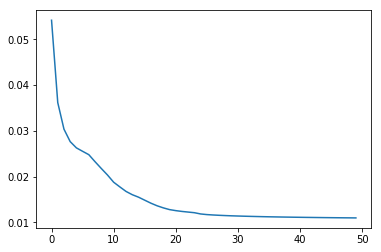

In [7]:
X_ph, encoded, decoded, loss, train_op = basic_ae(32, 784)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
training_loss = []
n_batches = 300 # that will lead to a batch size of 200
batches = np.split(x_train, n_batches)
np.random.shuffle(batches)
n_epoches = 50

for epoch in range(n_epoches):
    batch_loss = 0
    for b in batches:
        _, losses = sess.run([train_op, loss], feed_dict={X_ph: b})
        batch_loss += losses
    training_loss.append(batch_loss/n_batches)
    print(f'{epoch+1}/{n_epoches} finished, training loss: {batch_loss/n_batches}')
plt.plot(training_loss)
plt.show()

In [12]:
def model_summary():
    model_vars = tf.trainable_variables()
    slim.model_analyzer.analyze_vars(model_vars, print_info=True)

model_summary()

---------
Variables: name (type shape) [size]
---------
Variable:0 (float32_ref 784x32) [25088, bytes: 100352]
Variable_1:0 (float32_ref 32) [32, bytes: 128]
Variable_2:0 (float32_ref 32x784) [25088, bytes: 100352]
Variable_3:0 (float32_ref 784) [784, bytes: 3136]
Variable_4:0 (float32_ref 784x32) [25088, bytes: 100352]
Variable_5:0 (float32_ref 32) [32, bytes: 128]
Variable_6:0 (float32_ref 32x784) [25088, bytes: 100352]
Variable_7:0 (float32_ref 784) [784, bytes: 3136]
Variable_8:0 (float32_ref 784x32) [25088, bytes: 100352]
Variable_9:0 (float32_ref 32) [32, bytes: 128]
Variable_10:0 (float32_ref 32x784) [25088, bytes: 100352]
Variable_11:0 (float32_ref 784) [784, bytes: 3136]
Variable_12:0 (float32_ref 784x32) [25088, bytes: 100352]
Variable_13:0 (float32_ref 32) [32, bytes: 128]
Variable_14:0 (float32_ref 32x784) [25088, bytes: 100352]
Variable_15:0 (float32_ref 784) [784, bytes: 3136]
Total size of variables: 203968
Total bytes of variables: 815872


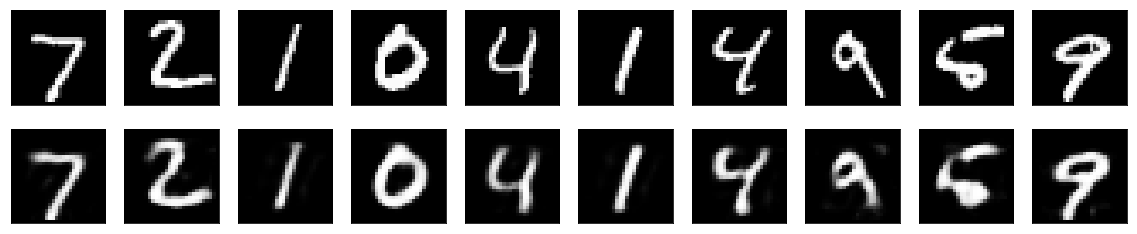

In [8]:
decoded_imgs = sess.run(decoded, feed_dict={X_ph: x_test})
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Adding Sparsity Constraint - L1 Regularization

1/50 finished, training loss: 0.026814744441459575
2/50 finished, training loss: 0.00894697119637082
3/50 finished, training loss: 0.006522539646054307
4/50 finished, training loss: 0.005535784790602823
5/50 finished, training loss: 0.004966551414690911
6/50 finished, training loss: 0.004563838836426536
7/50 finished, training loss: 0.004270803425461054
8/50 finished, training loss: 0.004024802698598554
9/50 finished, training loss: 0.003810308403335512
10/50 finished, training loss: 0.0036228844872675837
11/50 finished, training loss: 0.003462428884425511
12/50 finished, training loss: 0.0033153218613006176
13/50 finished, training loss: 0.0031799455049137276
14/50 finished, training loss: 0.003048590891994536
15/50 finished, training loss: 0.002946427188192805
16/50 finished, training loss: 0.002850753433691959
17/50 finished, training loss: 0.0027614191841954985
18/50 finished, training loss: 0.0027018483409968516
19/50 finished, training loss: 0.002634278212984403
20/50 finished, t

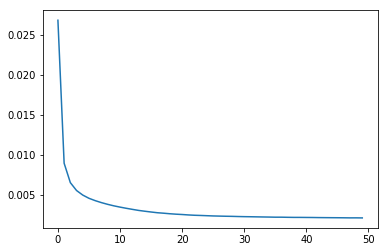

In [25]:
# close the previous tf.Session
sess.close()

X_ph, encoded, decoded, loss, train_op = basic_ae(806, 784, reg='l1', reg_param=0.1)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
n_epoches = 50
training_loss = []
for epoch in range(n_epoches):
    batch_loss = 0
    for b in batches:
        _, losses = sess.run([train_op, loss], feed_dict={X_ph: b})
        batch_loss += losses
    training_loss.append(batch_loss/n_batches)
    print(f'{epoch+1}/{n_epoches} finished, training loss: {batch_loss/n_batches}')
plt.plot(training_loss)
plt.show()

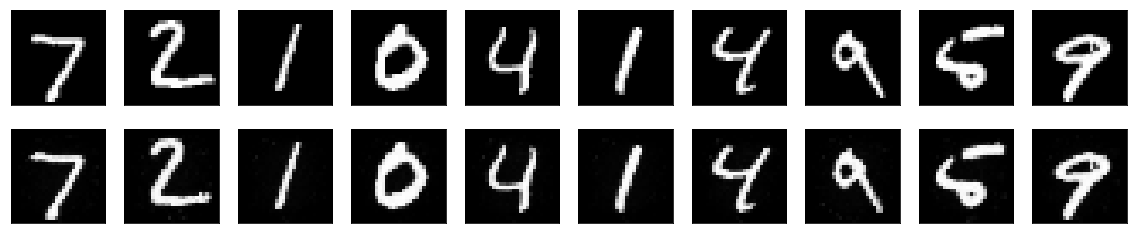

In [26]:
decoded_imgs = sess.run(decoded, feed_dict={X_ph: x_test})
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Dropout Regularization

1/50 finished, training loss: 0.06807032850881417
2/50 finished, training loss: 0.05635918950041135
3/50 finished, training loss: 0.053448491903642814
4/50 finished, training loss: 0.052039109642306965
5/50 finished, training loss: 0.051134289056062696
6/50 finished, training loss: 0.050258953707913556
7/50 finished, training loss: 0.04986246893803278
8/50 finished, training loss: 0.04951033283025026
9/50 finished, training loss: 0.049239062952498594
10/50 finished, training loss: 0.04868514828383923
11/50 finished, training loss: 0.047976406142115596
12/50 finished, training loss: 0.04749754219005505
13/50 finished, training loss: 0.04665686894208193
14/50 finished, training loss: 0.04634245047966639
15/50 finished, training loss: 0.04624158054590225
16/50 finished, training loss: 0.04609068534026543
17/50 finished, training loss: 0.04595416684945424
18/50 finished, training loss: 0.04590937143812577
19/50 finished, training loss: 0.04582287860413392
20/50 finished, training loss: 0.0

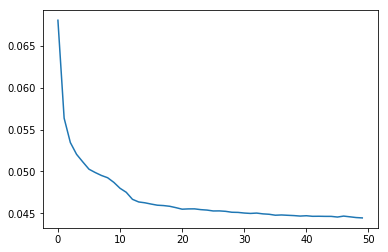

In [15]:
# close the previous tf.Session
sess.close()

X_ph, encoded, decoded, loss, train_op = basic_ae(32, 784, reg='dropout', reg_param=0.1)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
n_epoches = 50
training_loss = []
for epoch in range(n_epoches):
    batch_loss = 0
    for b in batches:
        _, losses = sess.run([train_op, loss], feed_dict={X_ph: b})
        batch_loss += losses
    training_loss.append(batch_loss/n_batches)
    print(f'{epoch+1}/{n_epoches} finished, training loss: {batch_loss/n_batches}')
plt.plot(training_loss)
plt.show()

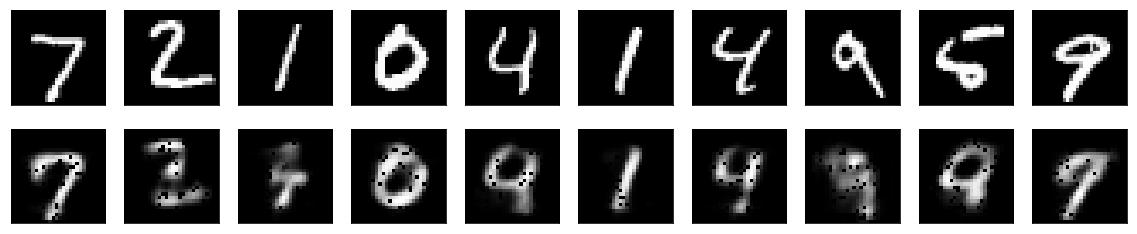

In [16]:
decoded_imgs = sess.run(decoded, feed_dict={X_ph: x_test})
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
sess.close()

In [19]:
x_train.shape

(60000, 784)

## Denoising AE

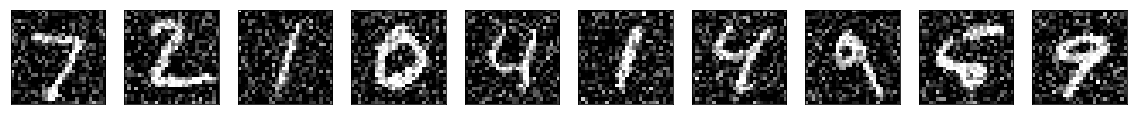

In [21]:
noise_factor = 0.3
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [22]:
sess.close()
def denoise_ae(n_hidden, input_dim, reg=None, reg_param=0.1):
    initializer = tf.variance_scaling_initializer()
    X_ph = tf.placeholder(tf.float32, shape=(None, input_dim)) # noisy input
    Y_ph = tf.placeholder(tf.float32, shape=(None, input_dim)) # orginal data
    W_1 = tf.Variable(initializer([input_dim, n_hidden]), dtype=tf.float32)
    b_1 = tf.Variable(tf.zeros(n_hidden), dtype=tf.float32)
    z_1 = tf.matmul(X_ph, W_1) + b_1
    a_1 = tf.nn.sigmoid(z_1)
    if reg == 'dropout':
        encoded = tf.nn.dropout(a_1, rate=reg_param) # reg_param = 1 - keep_prob here
    else:
        encoded = a_1
    W_2 = tf.Variable(initializer([n_hidden, input_dim]), dtype=tf.float32)
    b_2 = tf.Variable(tf.zeros(input_dim), dtype=tf.float32)
    z_2 = tf.matmul(encoded, W_2) + b_2
    a_2 = tf.nn.sigmoid(z_2)
    if reg == 'dropout':
        decoded = tf.nn.dropout(a_2, rate=reg_param) # reg_param = 1 - keep_prob here
    else:
        decoded = a_2
    
    
    if reg == 'l1':
        reg_factor = tf.constant(reg_param)
        loss = tf.reduce_mean(tf.square(decoded-Y_ph)) +\
                reg_factor*(tf.reduce_mean(tf.abs(W_1)) + tf.reduce_mean(tf.abs(W_2)))
    else:
        loss = tf.reduce_mean(tf.square(decoded-Y_ph))
    optimizer = tf.train.AdamOptimizer(0.01)
    train_op = optimizer.minimize(loss)
    
    return X_ph, Y_ph, encoded, decoded, loss, train_op

# we enlarge the number of hidden units to 64 as this is more difficult task
X_ph, Y_ph, encoded, decoded, loss, train_op = denoise_ae(64, 784, reg='l1', reg_param=0.1)

In [12]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
training_loss = []

# we need to shuffle two datasets at the same time, so might as well shuffle the indexing
batch_index = np.split(np.arange(x_train.shape[0]), n_batches)
np.random.shuffle(batch_index)
n_epoches = 50

for epoch in range(n_epoches):
    batch_loss = 0
    for idx in batch_index:
        _, losses = sess.run([train_op, loss], feed_dict={X_ph: x_train_noisy[idx],
                                                            Y_ph: x_train[idx]})
        batch_loss += losses
    training_loss.append(batch_loss/n_batches)
    print(f'{epoch+1}/{n_epoches} finished, training loss: {batch_loss/n_batches}')
plt.plot(training_loss[1:])
plt.show()

NameError: name 'n_batches' is not defined

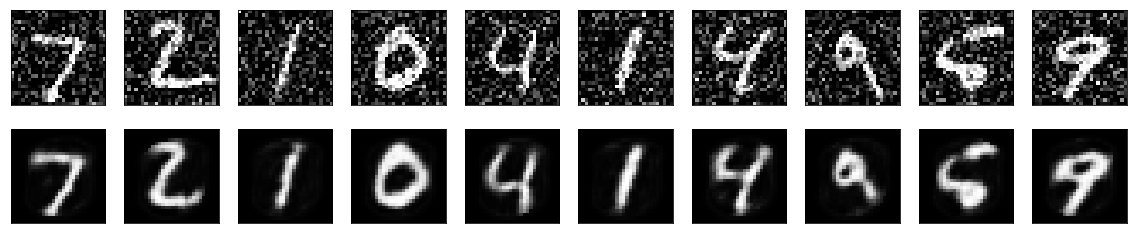

In [24]:
decoded_imgs = sess.run(decoded, feed_dict={X_ph: x_test_noisy})
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
sess.close()

## Contractive AE
> Instead of L-1 or Dropout, CAE uses Frobenius norm of the Jacobian matrix. The purpose is to make the learned representation to be robust towards small changes around the training examples.<br>
The current implementation of calculating the Frobenius norm of the Jacobian in tensorflow is not very efficient, thus the training takes much longer than other form of AEs.

In [14]:
def contractive_ae(n_hidden, input_dim, reg_param=0.1):
    initializer = tf.variance_scaling_initializer()
    X_ph = tf.placeholder(tf.float32, shape=(None, input_dim))
    W_1 = tf.Variable(initializer([input_dim, n_hidden]), dtype=tf.float32)
    b_1 = tf.Variable(tf.zeros(n_hidden), dtype=tf.float32)
    z_1 = tf.matmul(X_ph, W_1) + b_1
    encoded = tf.nn.sigmoid(z_1)
    W_2 = tf.Variable(initializer([n_hidden, input_dim]), dtype=tf.float32)
    b_2 = tf.Variable(tf.zeros(input_dim), dtype=tf.float32)
    z_2 = tf.matmul(encoded, W_2) + b_2
    decoded = tf.nn.sigmoid(z_2)
    
    # Frobenius norm of the Jacobian
    contractive_loss = tf.reduce_sum(tf.square([tf.gradients(encoded[i], X_ph
                                              ) for i in range(n_hidden)]))

    loss = tf.reduce_mean(tf.square(decoded-X_ph)) + \
            tf.constant(reg_param)*contractive_loss
    optimizer = tf.train.AdamOptimizer(0.01)
    train_op = optimizer.minimize(loss)
    
    return X_ph, encoded, decoded, loss, train_op

Instructions for updating:
Use tf.cast instead.
1/50 finished, training loss: 0.1573778299614787
2/50 finished, training loss: 0.06731666043400765
3/50 finished, training loss: 0.06678697798401118
4/50 finished, training loss: 0.06598704235007366
5/50 finished, training loss: 0.06416698717822632
6/50 finished, training loss: 0.06080275213966767
7/50 finished, training loss: 0.05744782062868277
8/50 finished, training loss: 0.05377724268784126
9/50 finished, training loss: 0.05054970702777306
10/50 finished, training loss: 0.04494619999080896
11/50 finished, training loss: 0.04487646515170733
12/50 finished, training loss: 0.04330905565371116
13/50 finished, training loss: 0.042283850125968456
14/50 finished, training loss: 0.03930173558493455
15/50 finished, training loss: 0.039788510613143445
16/50 finished, training loss: 0.03864819242308537
17/50 finished, training loss: 0.03870044524470965
18/50 finished, training loss: 0.03899470369021098
19/50 finished, training loss: 0.038902685

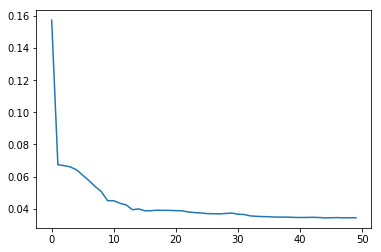

In [15]:
# close the previous session
sess.close()

X_ph, encoded, decoded, loss, train_op = contractive_ae(32, 784)
sess = tf.Session()
sess.run(tf.global_variables_initializer())
training_loss = []
n_batches = 300 # that will lead to a batch size of 200
batches = np.split(x_train, n_batches)
np.random.shuffle(batches)
n_epoches = 50

for epoch in range(n_epoches):
    batch_loss = 0
    for b in batches:
        _, losses = sess.run([train_op, loss], feed_dict={X_ph: b})
        batch_loss += losses
    training_loss.append(batch_loss/n_batches)
    print(f'{epoch+1}/{n_epoches} finished, training loss: {batch_loss/n_batches}')
plt.plot(training_loss)
plt.show()

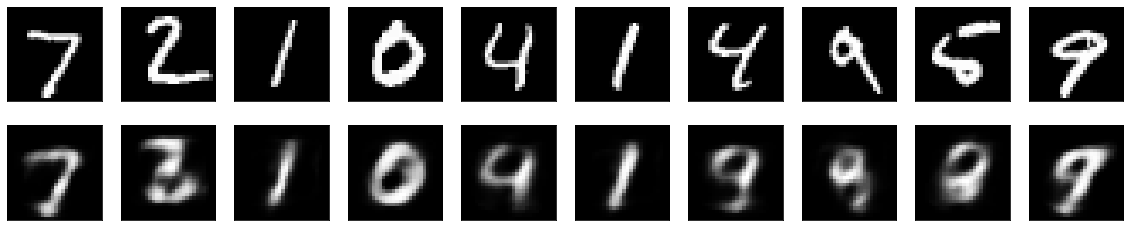

In [16]:
decoded_imgs = sess.run(decoded, feed_dict={X_ph: x_test})
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Variational AE (version 1 and version 2)
> This model can create new images like GAN


>Designed a VAE on Tensorflow which learned the features of MNIST digit

Version 1

In [6]:

def variational_ae_version1(n_hidden, input_dim, reg_param=0.1):
    def vae_loss(x_reconstructed, x_true):
        # Reconstruction loss
        encode_decode_loss = x_true * tf.log(1e-10 + x_reconstructed) \
                             + (1 - x_true) * tf.log(1e-10 + 1 - x_reconstructed)
        encode_decode_loss = -tf.reduce_sum(encode_decode_loss, 1)
        return tf.reduce_mean(encode_decode_loss )
    
    initializer = tf.variance_scaling_initializer()
    X_ph = tf.placeholder(tf.float32, shape=(None, input_dim))
    W_1 = tf.Variable(initializer([input_dim, n_hidden]), dtype=tf.float32)
    b_1 = tf.Variable(tf.zeros(n_hidden), dtype=tf.float32)
    encoded = tf.matmul(X_ph, W_1) + b_1
    encoded = tf.nn.sigmoid(encoded)
    
    W_2 = tf.Variable(initializer([n_hidden, input_dim]), dtype=tf.float32)
    b_2 = tf.Variable(tf.zeros(input_dim), dtype=tf.float32)
    decoded = tf.matmul(encoded, W_2) + b_2
    decoded = tf.nn.sigmoid(decoded)
        
    loss = vae_loss(decoded, X_ph)
    optimizer = tf.train.AdamOptimizer(0.01)
    train_op = optimizer.minimize(loss)
    
    init = tf.global_variables_initializer()

    # Start training
    with tf.Session() as sess:

        # Run the initializer
        sess.run(init)

        for i in range(1, 50):

            batch_loss = 0
            for b in batches:
                feed_dict = {X_ph: b}
                _, l = sess.run([train_op, loss], feed_dict=feed_dict)
            print('Step %i, Loss: %f' % (i, l))
    return X_ph, encoded, decoded, loss, train_op

Step 1, Loss: 143.328735
Step 2, Loss: 131.579315
Step 3, Loss: 126.615257
Step 4, Loss: 121.012833
Step 5, Loss: 115.529846
Step 6, Loss: 111.493240
Step 7, Loss: 103.401443
Step 8, Loss: 95.266472
Step 9, Loss: 89.734695
Step 10, Loss: 87.075584
Step 11, Loss: 85.036491
Step 12, Loss: 83.029579
Step 13, Loss: 81.807198
Step 14, Loss: 80.555916
Step 15, Loss: 79.877884
Step 16, Loss: 79.334114
Step 17, Loss: 78.894066
Step 18, Loss: 78.508369
Step 19, Loss: 78.174988
Step 20, Loss: 77.889786
Step 21, Loss: 77.648994
Step 22, Loss: 77.442177
Step 23, Loss: 77.271286
Step 24, Loss: 77.125603
Step 25, Loss: 77.005219
Step 26, Loss: 76.903328
Step 27, Loss: 76.817390
Step 28, Loss: 76.742065
Step 29, Loss: 76.675758
Step 30, Loss: 76.615334
Step 31, Loss: 76.563675
Step 32, Loss: 76.510254
Step 33, Loss: 76.467133
Step 34, Loss: 76.426712
Step 35, Loss: 76.383087
Step 36, Loss: 76.346687
Step 37, Loss: 76.311844
Step 38, Loss: 76.272324
Step 39, Loss: 76.244873
Step 40, Loss: 76.210617
St

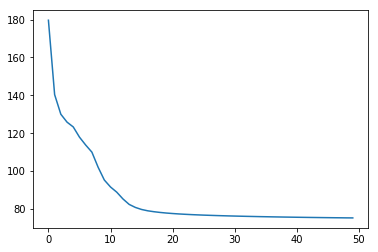

In [8]:
#Same output exa.

training_loss = []
n_batches = 300 # that will lead to a batch size of 200
batches = np.split(x_train, n_batches)
np.random.shuffle(batches)
n_epoches = 50

X_ph, encoded, decoded, loss, train_op = variational_ae_version1(32, 784)

sess = tf.Session()
sess.run(tf.global_variables_initializer())


for epoch in range(n_epoches):
    batch_loss = 0
    for b in batches:
        _, losses = sess.run([train_op, loss], feed_dict={X_ph: b})
        batch_loss += losses
    training_loss.append(batch_loss/n_batches)
    print(f'{epoch+1}/{n_epoches} finished, training loss: {batch_loss/n_batches}')
plt.plot(training_loss)
plt.show()

Version 2

In [9]:
def vae_loss2(x_reconstructed, x_true,z_std,z_mean):
    # Reconstruction loss
    encode_decode_loss = x_true * tf.log(1e-10 + x_reconstructed) \
                         + (1 - x_true) * tf.log(1e-10 + 1 - x_reconstructed)
    encode_decode_loss = -tf.reduce_sum(encode_decode_loss, 1)
    
    # KL Divergence loss
    kl_div_loss = 1 + z_std - tf.square(z_mean) - tf.exp(z_std)
    kl_div_loss = -0.5 * tf.reduce_sum(kl_div_loss, 1)

    return tf.reduce_mean(encode_decode_loss + kl_div_loss )

def variational_ae_version2(n_hidden,latent_dim, input_dim, reg_param=0.1):
    
    # Variables
    weights = {
        'encoder_h1': tf.Variable(tf.random_normal(shape=[image_dim, hidden_dim], stddev=1. / tf.sqrt(image_dim / 2.))),
        'z_mean': tf.Variable(tf.random_normal(shape=[hidden_dim, latent_dim], stddev=1. / tf.sqrt(hidden_dim / 2.))),
        'z_std': tf.Variable(tf.random_normal(shape=[hidden_dim, latent_dim], stddev=1. / tf.sqrt(hidden_dim / 2.))),
        'decoder_h1': tf.Variable(tf.random_normal(shape=[latent_dim, hidden_dim], stddev=1. / tf.sqrt(latent_dim / 2.))),
        'decoder_out': tf.Variable(tf.random_normal(shape=[hidden_dim,image_dim], stddev=1. / tf.sqrt(hidden_dim / 2.)))
    }
    biases = {
        'encoder_b1': tf.Variable(tf.random_normal(shape=[hidden_dim], stddev=1. / tf.sqrt(hidden_dim / 2.))),
        'z_mean': tf.Variable(tf.random_normal(shape=[latent_dim], stddev=1. / tf.sqrt(latent_dim / 2.))),
        'z_std': tf.Variable(tf.random_normal(shape=[latent_dim], stddev=1. / tf.sqrt(latent_dim / 2.))),
        'decoder_b1': tf.Variable(tf.random_normal(shape=[hidden_dim], stddev=1. / tf.sqrt(hidden_dim / 2.))),
        'decoder_out': tf.Variable(tf.random_normal(shape=[image_dim], stddev=1. / tf.sqrt(image_dim / 2.))),
    }
    
    
    initializer = tf.variance_scaling_initializer()
    
    input_image = tf.placeholder(tf.float32, shape=[None, image_dim])        
    '''
    X_ph = tf.placeholder(tf.float32, shape=(None, input_dim))
    W_1 = tf.random_normal(shape=[input_dim, n_hidden], stddev=1. / tf.sqrt(input_dim / 2.))
    b_1 = tf.random_normal(shape=[n_hidden], stddev=1. / tf.sqrt(n_hidden / 2.))
    '''
    z_1 = tf.matmul(X_ph, weights['encoder_h1']) + biases['encoder_b1']


    encoder = tf.nn.tanh(z_1)
    z_mean = tf.matmul(encoder, weights['z_mean']) + biases['z_mean']
    z_std = tf.matmul(encoder, weights['z_std']) + biases['z_std']

    # Sampler: Normal (gaussian) random distribution
    eps = tf.random_normal(tf.shape(z_std), dtype=tf.float32, mean=0., stddev=1.0,
                           name='epsilon')
    z = z_mean + tf.exp(z_std / 2) * eps

    # decoder parameters
    '''
    This type usage didn't share the weights to test part...
    W_2 =tf.random_normal(shape=[latent_dim,n_hidden], stddev=1. / tf.sqrt(n_hidden / 2.))
    b_2 = tf.random_normal(shape=[n_hidden], stddev=1. / tf.sqrt(n_hidden / 2.))
    
    W_3 = tf.random_normal(shape=[n_hidden,input_dim], stddev=1. / tf.sqrt(n_hidden / 2.))
    b_3 = tf.Variable(tf.zeros(input_dim), dtype=tf.float32)
    '''
    decoder = tf.matmul(z, weights['decoder_h1']) + biases['decoder_b1']
    decoder = tf.nn.tanh(decoder)
    decoder = tf.matmul(decoder, weights['decoder_out']) + biases['decoder_out']
    decoded = tf.nn.sigmoid(decoder)
    
    
    loss = vae_loss2(decoded, X_ph,z_std,z_mean)
    optimizer = tf.train.RMSPropOptimizer(learning_rate=0.001)
    train_op = optimizer.minimize(loss)
    
    init = tf.global_variables_initializer()

    # Start training
    with tf.Session() as sess:

        # Run the initializer
        sess.run(init)

        for i in range(1, 50):
            batch_loss = 0
            for b in batches:
                feed_dict = {X_ph: b}
                _, l = sess.run([train_op, loss], feed_dict=feed_dict)
            if i % 10 == 0 or i == 1:
                print('Step %i, Loss: %f' % (i, l))
        # Building a manifold of generated digits

        noise_input = tf.placeholder(tf.float32, shape=[None, latent_dim])
        # Rebuild the decoder to create image from noise

        decoder = tf.matmul(noise_input, weights['decoder_h1']) + biases['decoder_b1']
        decoder = tf.nn.tanh(decoder)
        decoder = tf.matmul(decoder, weights['decoder_out']) + biases['decoder_out']
        decoded = tf.nn.sigmoid(decoder)


        n = 20
        x_axis = np.linspace(-3, 3, n)
        y_axis = np.linspace(-3, 3, n)
        #testing
        canvas = np.empty((28 * n, 28 * n))
        for i, yi in enumerate(x_axis):
            for j, xi in enumerate(y_axis):
                z_mu = np.array([[xi, yi]] * n_batches)
                x_mean = sess.run(decoded, feed_dict={noise_input: z_mu})
                canvas[(n - i - 1) * 28:(n - i) * 28, j * 28:(j + 1) * 28] = \
                x_mean[0].reshape(28, 28)

        plt.figure(figsize=(8, 10))
        Xi, Yi = np.meshgrid(x_axis, y_axis)
        plt.imshow(canvas, origin="upper", cmap="gray")
        plt.show()

Step 1, Loss: 196.977936
Step 10, Loss: 166.264374
Step 20, Loss: 161.425781
Step 30, Loss: 158.422775
Step 40, Loss: 156.233200


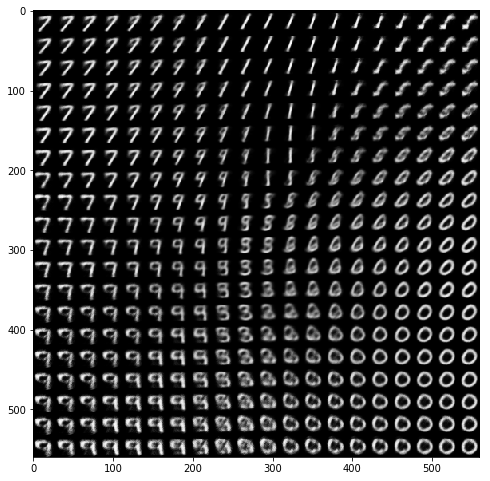

In [10]:
variational_ae_version2(32,2, image_dim, reg_param=0.1)